In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns 

In [4]:
import tensorflow as tf

In [5]:
from tensorflow import keras

In [6]:
from tensorflow.keras import Layer 

In [7]:
from tensorflow.keras.models import Sequential 

In [8]:
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D

In [9]:
from tensorflow.keras import layers, optimizers, callbacks

In [10]:
from sklearn.utils.class_weight import compute_class_weight

In [11]:
from tensorflow.keras.applications import EfficientNetV2B2

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
import gradio as gr

# 1. Explore and Understand the Data

Load image dataset using tools like image_dataset_from_directory.

Visualize sample images from each class.

Check the number of images per class to ensure balance.

Understand image dimensions, color channels, and class labels.

# Load image dataset using tools like image_dataset_from_directory

# Split data into training, validation, and testing sets.
tf.keras.utils.image_dataset_from_directory(...)
Used to load images from a directory where each subfolder represents a class.


path

Root directory path containing one subdirectory per class.


shuffle=True

Randomly shuffles the image data. Useful during training to prevent the model from learning the order of the data.


image_size=(128, 128)

Resizes all loaded images to this target size (width, height).
This must match the input size expected by the model.


batch_size=32

Number of images per batch during training.
This affects memory usage and the frequency of model updates.


validation_split=False

If set to a float (e.g., 0.2), splits a portion of the data for validation.
If False, no split is applied.# 

In [14]:
dataset_dir= r"C:\Users\esire\OneDrive\Desktop\datasets\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [16]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [17]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [18]:

print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


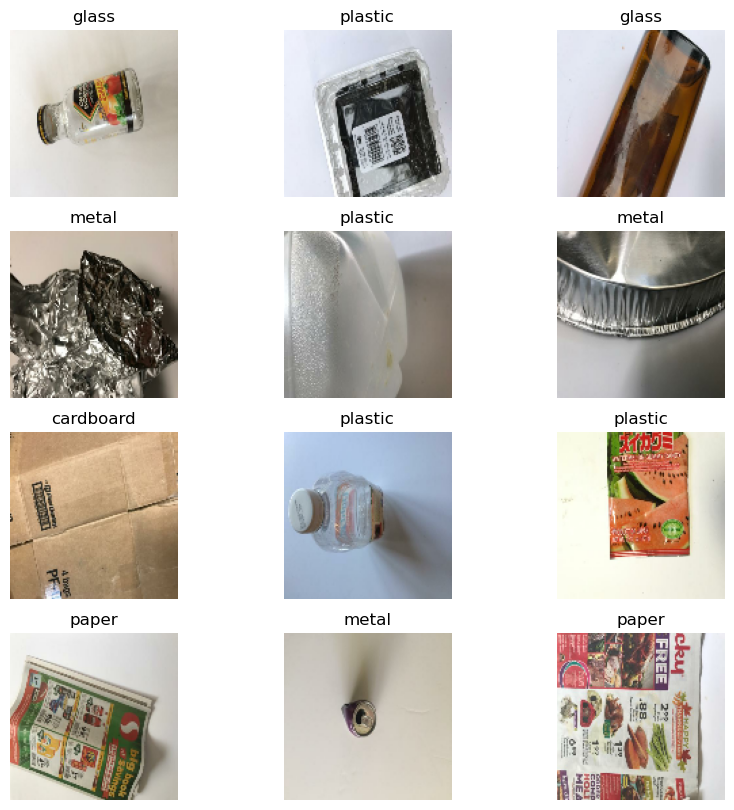

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Check the number of images per class to ensure balance

# Understand image properties like Image dimensions, Class labels

In [20]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts



In [21]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [22]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


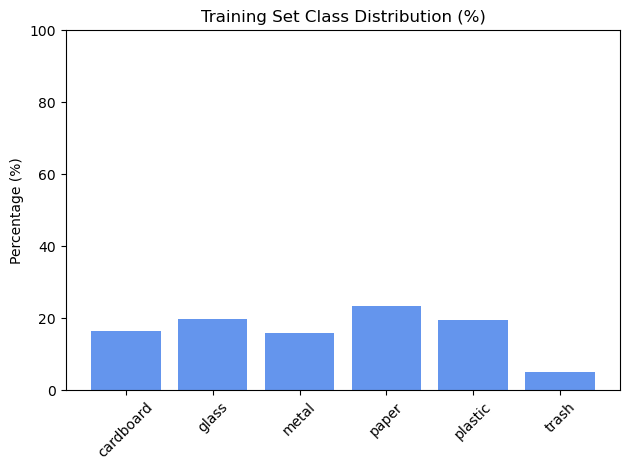

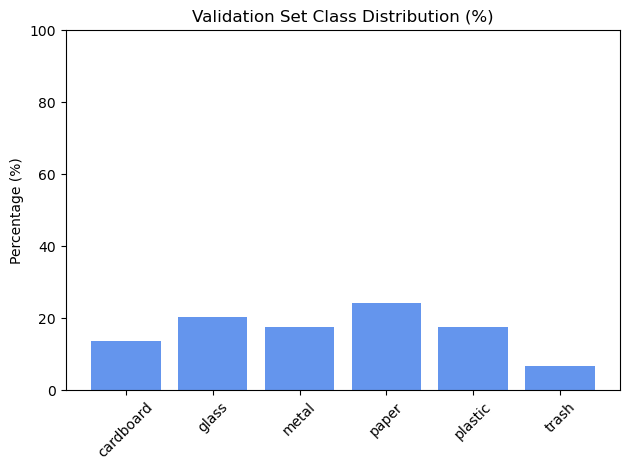

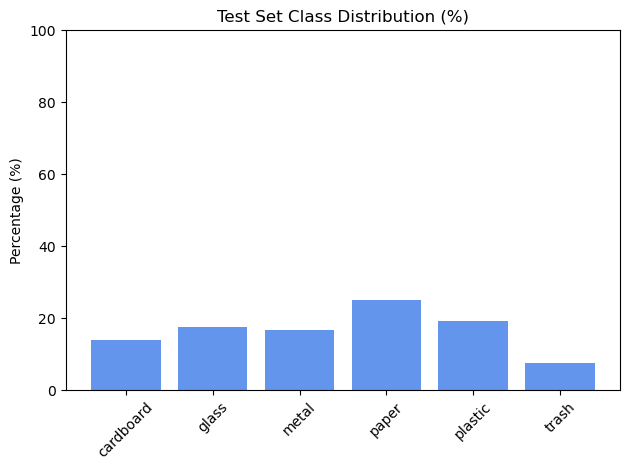

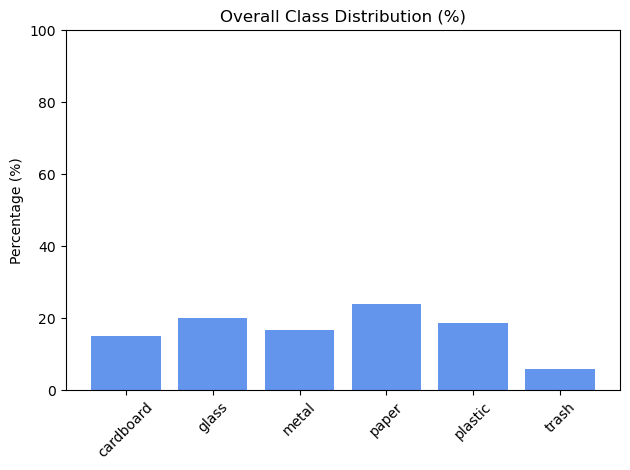

In [23]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

# Inference on Class Imbalance
The "Garbage Image Dataset" reveals a noticeable imbalance in the distribution of its image categories:

Category	Image Count	Updated Distribution
Cardboard	403	15.09
Glass	    501	19.96
Metal	    410	16.68
Paper	    594	23.82
Plastic	    482	18.53
Trash	    137	5.91

Analogy:

Imagine teaching a child to identify animals by showing them 95 pictures of cats and just 5 pictures of dogs.
They'd probably think most pets are cats, right?
Similarly, our model sees a lot of "paper" and very little "trash", which biases its understanding.

Key Problems Caused by Class Imbalance:

1️ Bias
The model may overpredict common classes like "paper" and underpredict rare ones like "trash".

2️ Generalization Issues
If the real-world distribution is more balanced, the model may fail to generalize and misclassify rare classes.

3️ Accuracy Deception
The model might appear to have high overall accuracy just by predicting the majority class, while failing on underrepresented ones.

Solution Approaches :

Use class weights to handle imbalanced data in training,
Apply data augmentation to increase training data diversity
Conclusion: Always check class distribution. A seemingly "accurate" model might just be biased toward the dominant class.

🛠️ Addressing Imbalance Using Class Weights:
To tackle our imbalanced image dataset, we'll utilize class weights. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like compute_class_weight from scikit-learn, based on the distribution of images in each class. The formula is:

weight(class)=total samplesnumber of classes×samples in that class

These computed weights are then passed to the model.

In [ ]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [25]:

# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


# 2.Data Preprocessing / Preparation

Resize and rescale images.

Apply data augmentation (e.g., RandomFlip, RandomRotation, RandomZoom) to improve generalization.

Normalize images (using preprocess_input if using pre-trained models like EfficientNet).# 

In [26]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# 3. Model Selection

Choose a base model: Custom CNN or Transfer Learning (e.g., EfficientNetV2B2).

Decide whether to use pre-trained weights (e.g., ImageNet).

Define whether layers should be trainable or frozen during initial training.

In [27]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


# 4. Model Training

Build the model architecture using Sequential or Functional API.

Compile the model with loss function ( sparse_categorical_crossentropy), optimizer (e.g., Adam), and evaluation metrics (accuracy).

# 5. Model Tuning and Optimization

Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.

Use callbacks: EarlyStopping,

Optionally perform fine-tuning on pre-trained models by unfreezing some layers.

# Model Architecture and Layer Utilities

Sequential: A simple way to build models by stacking layers one after the other in a linear fashion.

RandomFlip: A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

RandomRotation: Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

RandomZoom: Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

Dropout: A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

GlobalAveragePooling2D: Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

Dense: A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

Input: Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

EfficientNetV2B2: A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.

In [28]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [29]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# 🔁 Callbacks
EarlyStopping: To stop training when validation performance stops improving

In [32]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


# Train the model using .fit() with appropriate epochs, batch_size, and callbacks like EarlyStopping.

In [33]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.4156 - loss: 1.4924 - val_accuracy: 0.6257 - val_loss: 1.0927
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6774 - loss: 0.9793 - val_accuracy: 0.7703 - val_loss: 0.7503
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8036 - loss: 0.6409 - val_accuracy: 0.8158 - val_loss: 0.5739
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8580 - loss: 0.4518 - val_accuracy: 0.8752 - val_loss: 0.4403
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8840 - loss: 0.3501 - val_accuracy: 0.8792 - val_loss: 0.3914
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9141 - loss: 0.2675 - val_accuracy: 0.8871 - val_loss: 0.3650
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9298 - loss: 0.2227 - val_accuracy: 0.9030 - val_loss: 0.3243
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9467 - loss: 0.1852 - val_accuracy: 0.8891 - val_loss:

In [34]:
# 📝 Summary (optional but useful)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [35]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 124, 124, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 124, 124, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 124, 124, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 62, 62, 32)        │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 62, 62, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 62, 62, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 62, 62, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 62, 62, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 62, 62, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 62, 62, 16)        │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 62, 62, 16)        │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 62, 62, 16)        │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 62, 62, 16)        │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 62, 62, 16)        │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 31, 31, 64)        │           9,21

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

# Model Performance Visualization: Accuracy & Loss Trends

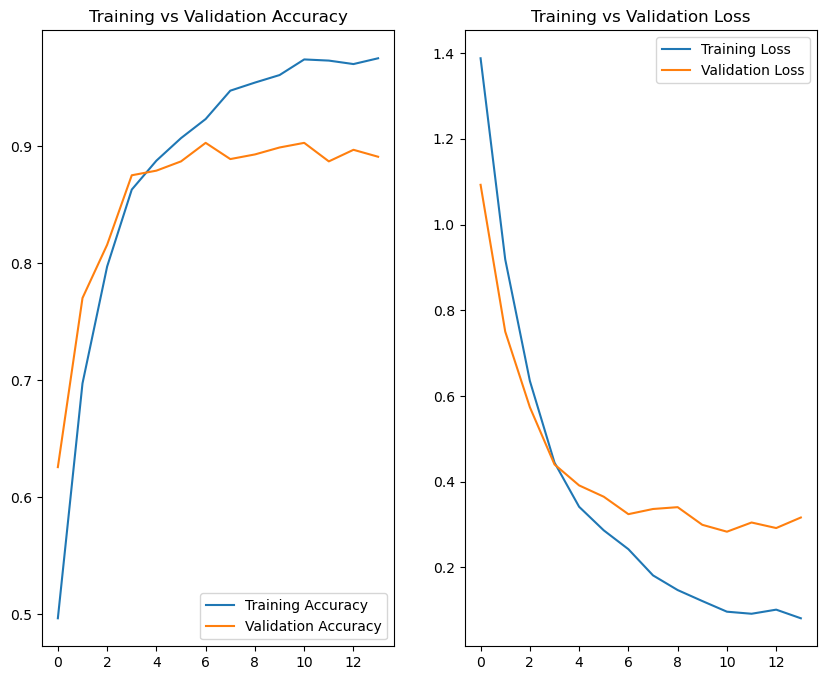

In [36]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

# 5. Model Evaluation

Plot training and validation accuracy/loss curves.

Evaluate model performance on validation or test set.

Use metrics like:

Confusion Matrix

Classification Report (Precision, Recall, F1-score)

confusion_matrix, classification_report: To evaluate the model's classification performance.

In [37]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.9045 - loss: 0.2957
Test accuracy is0.9023, Test loss is 0.3074


In [38]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step
[[31  0  0  5  0  0]
 [ 0 52  6  0  1  0]
 [ 0  0 42  0  0  0]
 [ 5  0  0 53  0  3]
 [ 1  3  0  1 35  0]
 [ 0  0  0  0  0 18]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        36
           1       0.95      0.88      0.91        59
           2       0.88      1.00      0.93        42
           3       0.90      0.87      0.88        61
           4       0.97      0.88      0.92        40
           5       0.86      1.00      0.92        18

    accuracy                           0.90       256
   macro avg       0.90      0.91      0.90       256
weighted avg       0.91      0.90      0.90       256



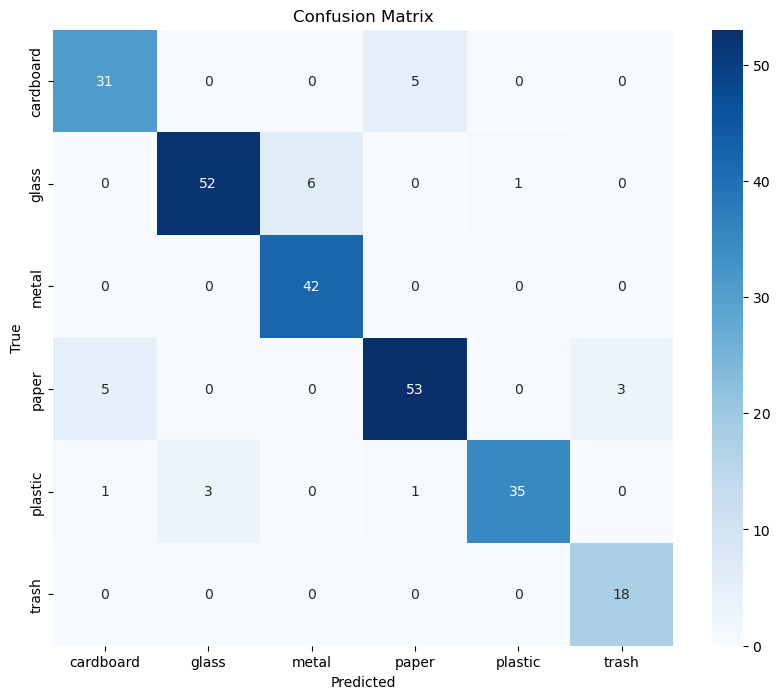

In [39]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

# 7. Final Testing and Save the Model
Evaluate the final model on the unseen test dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


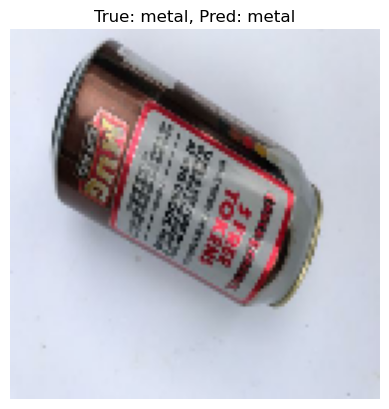

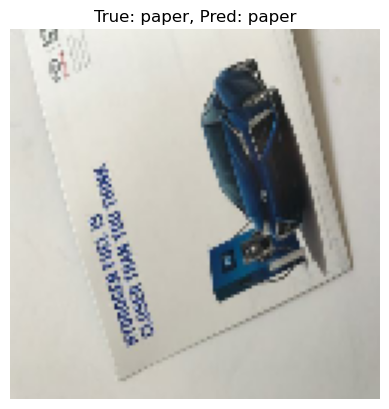

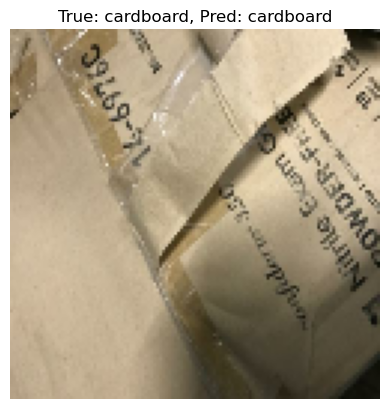

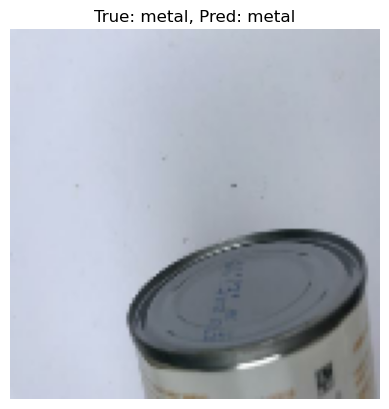

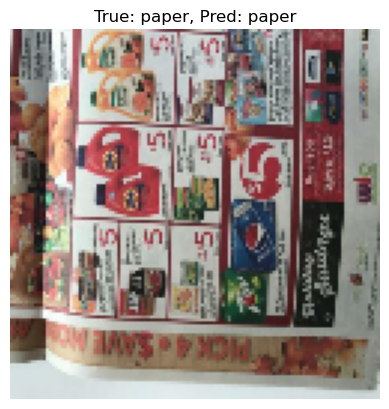

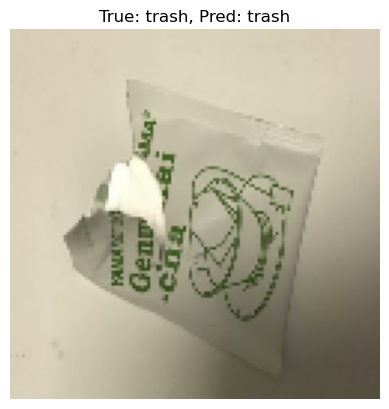

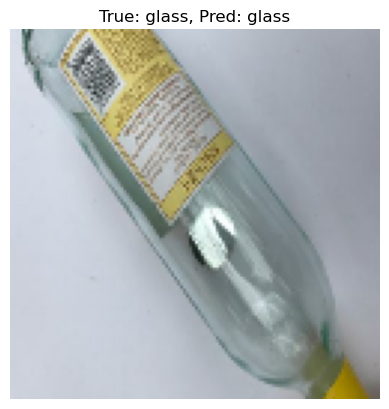

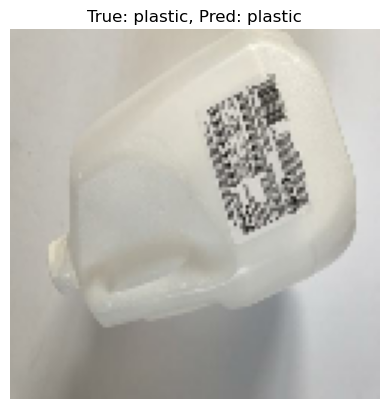

In [40]:
# Extract class names from the training dataset
class_names = train_ds.class_names  

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

# Save the trained model using model.save() or save_model() for future inference.

In [41]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

# 8. Model Deployment (Optional)
Create a web interface using Gradio.
Load the saved model and preprocess input images before prediction.

In [42]:
!pip install gradio

# 🌐 Gradio Interface and Preprocessing
gr: To build a web interface for the model.

PIL.Image: For handling image input in Gradio.

preprocess_input: Preprocessing method for EfficientNet.

load_model: For loading a saved model for inference.

In [43]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [44]:
def classify_image(img):  
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))  
    
    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Make a prediction using the trained model
    prediction = model.predict(img_array)  
    
    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)  
    
    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]  
    
    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]  
    
    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"  

In [46]:
iface = gr.Interface(  
    fn=classify_image,  # Function to classify image using the trained model  
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image  
    outputs="text"  # Outputs prediction as text  
)  

# Launch the interface  
iface.launch() # Start the Gradio interface for user interaction  

* Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


# Conclusion

The image classification model demonstrates strong accuracy in identifying objects, leveraging deep learning to refine predictions effectively. Its robust performance ensures reliable classification, making it a valuable tool for various applications.